# Nonlinear Classification
Under construction (3 Oct 2018)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
dtype = torch.float
import NeuralNetwork as NN
import Layer
import importlib
import time
from copy import deepcopy
from IPython.display import display
from ipywidgets import FloatProgress

importlib.reload(NN)
importlib.reload(Layer);

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

## Binary one-hot

### Dataset

In [199]:
# 8->5 binary one-hot
noise = 0.
n_samples = 100
s = np.array([[1,0,1,0,0,1,1,0],
                         [0,1,0,1,0,1,0,1],
                         [0,1,1,0,1,0,0,1],
                         [1,0,0,0,1,0,1,1],
                         [1,0,0,1,0,1,0,1]], dtype=float)
e = np.eye(5)
#s = s*2. - 1.
#e = e*2. - 1.
classes = len(s)
training_input = []
training_output = []
r = 0
for n in range(n_samples):
    training_input.append(np.array(s[r], dtype=float) + noise*np.random.normal(scale=0.01,size=len(s[r])))
    training_output.append(np.array(e[r], dtype=float))
    r = np.mod(r+1, classes) #r = np.random.randint(classes)

training_input = torch.tensor(training_input).float().to(device)
training_output = torch.tensor(training_output).float().to(device)
train = [training_input, training_output]

n_test_samples = 100
test_input = []
test_output = []
r = 0
for n in range(n_test_samples):
    test_input.append(np.array(s[r], dtype=float) + noise*np.random.normal(scale=0.01,size=len(s[r])))
    test_output.append(np.array(e[r], dtype=float))
    r = np.mod(r+1, classes) #np.random.randint(classes)

test_input = torch.tensor(test_input).float().to(device)
test_output = torch.tensor(test_output).float().to(device)
test = [test_input, test_output]

n_rand_samples = 10
rand_input = []
rand_output = []
r = 0
for n in range(n_test_samples):
    rand_input.append(np.random.rand(len(s[r])))
    rand_output.append(np.array(e[r], dtype=float))
    r = np.mod(r+1, classes) #np.random.randint(classes)

rand_input = torch.tensor(rand_input).float().to(device)
rand_output = torch.tensor(rand_output).float().to(device)
rand = [rand_input, rand_output]



for x, t in zip(s,e):
    print(str(np.array(x,dtype=int))+' -> '+str(t))

[1 0 1 0 0 1 1 0] -> [1. 0. 0. 0. 0.]
[0 1 0 1 0 1 0 1] -> [0. 1. 0. 0. 0.]
[0 1 1 0 1 0 0 1] -> [0. 0. 1. 0. 0.]
[1 0 0 0 1 0 1 1] -> [0. 0. 0. 1. 0.]
[1 0 0 1 0 1 0 1] -> [0. 0. 0. 0. 1.]


In [243]:
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=8))  # 0
net.AddLayer(Layer.PELayer(n=7))  # 1
net.AddLayer(Layer.PELayer(n=6))  # 2
net.AddLayer(Layer.TopPELayer(n=5))  # 3
net.Connect(0,1)
net.Connect(1,2)
net.Connect(2,3)
net.layers[0].SetActivationFunction('logistic')
net.layers[-1].SetActivationFunction('softmax')
net.SetTau(0.08)

### Train

In [259]:
train_shuffle = list(zip(train[0],train[1]))
batch_size = 10
net.learning_tau = torch.tensor(batch_size).float().to(device) * 5.
epochs = 20
fp = FloatProgress(min=0,max=epochs*len(train_shuffle))
display(fp)
T = 4.
start_time = time.time()
for k in range(epochs):
    np.random.shuffle(train_shuffle)
    unzip = list(zip(*train_shuffle))
    batches = NN.MakeBatches(unzip[0], unzip[1], batch_size)
    for x in batches:
        #net.Reset()
        net.Infer(T, x[0], x[1])
        fp.value += batch_size
end_time = time.time()
print('Total time: '+str(end_time-start_time))

A Jupyter Widget

Total time: 39.79322910308838


### Test

In [269]:
# Forward
net.Reset()
net.SetTau(0.03)  # it seems like choosing a value half of that during training works best
yy = net.Predict(10., test[0])
y_true = test[1]
y = np.array([np.array(net.layers[-1].sigma(k)) for k in yy])

for yy, t in zip(y[:10], y_true[:10]):
    #print(np.round(yy, decimals=3), np.array(t))
    print(np.round(np.array(yy)-np.array(t), decimals=3))

[-0.01   0.001  0.002  0.005  0.002]
[ 0.    -0.008  0.005  0.     0.002]
[ 0.001  0.001 -0.008  0.005  0.001]
[ 0.002  0.001  0.001 -0.006  0.002]
[ 0.     0.019  0.     0.    -0.019]
[-0.01   0.001  0.002  0.005  0.002]
[ 0.    -0.008  0.005  0.     0.002]
[ 0.001  0.001 -0.008  0.005  0.001]
[ 0.002  0.001  0.001 -0.006  0.002]
[ 0.     0.019  0.     0.    -0.019]


In [270]:
# Backward
net.Reset()
net.SetTau(0.08)  # it seems like choosing a value half of that during training works best
yy = net.Generate(10., test[1])
y_true = test[0]
y = yy

for yy, t in zip(y[:10], y_true[:10]):
    #print(np.round(np.array(yy), decimals=3),np.array(t))
    print(np.round(np.array(yy)-np.array(t), decimals=3))

[-0.023  0.031 -0.013  0.005  0.089 -0.081 -0.07   0.094]
[ 0.002  0.069  0.179 -0.052  0.191 -0.12  -0.123  0.138]
[ 0.051 -0.025 -0.038 -0.04  -0.009  0.035  0.18  -0.049]
[ 0.029 -0.008  0.171 -0.086 -0.003  0.024  0.045 -0.089]
[-0.232  0.21  -0.161  0.057 -0.034  0.013  0.037  0.023]
[-0.023  0.031 -0.013  0.005  0.089 -0.081 -0.07   0.094]
[ 0.002  0.069  0.179 -0.052  0.191 -0.12  -0.123  0.138]
[ 0.051 -0.025 -0.038 -0.04  -0.009  0.035  0.18  -0.049]
[ 0.029 -0.008  0.171 -0.086 -0.003  0.024  0.045 -0.089]
[-0.232  0.21  -0.161  0.057 -0.034  0.013  0.037  0.023]


## Binary Mapping

In [168]:
# 8->4 binary mapping
noise = 0.
n_samples = 100
s = np.array([[1,0,1,0,0,1,1,0],
                         [0,1,0,1,0,1,0,1],
                         [0,1,1,0,1,0,0,1],
                         [1,0,0,0,1,0,1,1],
                         [1,0,0,1,0,1,0,1]], dtype=float)
e = np.array([[0,1,0,1],[1,0,0,1],[1,0,1,1],[0,1,1,0],[1,0,1,0]])
#s = s*2. - 1.
#e = e*2. - 1.
classes = len(s)
training_input = []
training_output = []
r = 0
for n in range(n_samples):
    r = np.mod(r+1, classes) #r = np.random.randint(classes)
    training_input.append(np.array(s[r], dtype=float) + noise*np.random.normal(scale=0.01,size=len(s[r])))
    training_output.append(np.array(e[r], dtype=float))

training_input = torch.tensor(training_input).float().to(device)
training_output = torch.tensor(training_output).float().to(device)
train = [training_input, training_output]

n_test_samples = 100
test_input = []
test_output = []
r = 0
for n in range(n_test_samples):
    r = np.mod(r+1, classes) #np.random.randint(classes)
    test_input.append(np.array(s[r], dtype=float) + noise*np.random.normal(scale=0.01,size=len(s[r])))
    test_output.append(np.array(e[r], dtype=float))

test_input = torch.tensor(test_input).float().to(device)
test_output = torch.tensor(test_output).float().to(device)
test = [test_input, test_output]

for x, t in zip(s,e):
    print(str(np.array(x,dtype=int))+' -> '+str(t))

[1 0 1 0 0 1 1 0] -> [0 1 0 1]
[0 1 0 1 0 1 0 1] -> [1 0 0 1]
[0 1 1 0 1 0 0 1] -> [1 0 1 1]
[1 0 0 0 1 0 1 1] -> [0 1 1 0]
[1 0 0 1 0 1 0 1] -> [1 0 1 0]


In [173]:
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=8))
net.ConnectNextLayer(Layer.PELayer(n=7))
net.ConnectNextLayer(Layer.PELayer(n=6))
net.ConnectNextLayer(Layer.TopPELayer(n=4))
net.layers[0].SetActivationFunction('logistic')
net.layers[-1].SetActivationFunction('logistic')
net.SetTau(0.06)

## Polar Clusters

### Dataset

In [739]:
# Shear
alpha = 0.25
beta = -0.1
def RandomSample():
    x = np.random.rand(2)
    M = np.eye(2)
    M[0,1] = alpha
    M[1,0] = beta
    y = M@x
    return [x, y]

In [661]:
# Warp
def RandomSample():
    theta = ( np.random.rand()*2. - 1. ) * np.pi/8.
    rho = np.random.rand()*0.8 + 1.5
    y = np.array([rho-1.8, theta])
    x0 = rho*np.cos(theta) - 1.7
    x1 = rho*np.sin(theta)*0.5
    x = np.array([x0,x1])
    return [y, x]

In [662]:
RandomSample()

[array([ 0.43978421, -0.12849435]), array([ 0.52131932, -0.14350416])]

In [740]:
n_samples = 500
training_input = []
training_output = []
for idx in range(n_samples):
    blah = RandomSample()
    training_input.append(np.array(blah[0]))
    training_output.append(np.array(blah[1]))
training_input = torch.tensor(training_input).float().to(device)
training_output = torch.tensor(training_output).float().to(device)
train = [training_input, training_output]

testing_input = []
testing_output = []
for idx in range(n_samples):
    blah = RandomSample()
    testing_input.append(np.array(blah[0]))
    testing_output.append(np.array(blah[1]))
testing_input = torch.tensor(testing_input).float().to(device)
testing_output = torch.tensor(testing_output).float().to(device)
test = [testing_input, testing_output]

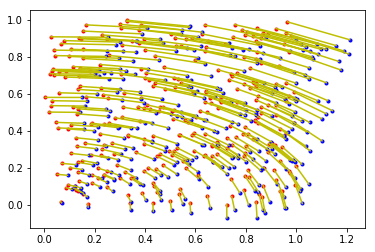

In [741]:
n = 300
plt.plot(np.array(testing_input[:n,0]), np.array(testing_input[:n,1]), 'r.');
plt.plot(np.array(testing_output[:n,0]), np.array(testing_output[:n,1]), 'b.');
for k in range(n):
    st = [testing_input[k,0], testing_output[k,0]]
    en = [testing_input[k,1], testing_output[k,1]]
    plt.plot(st, en, 'y')

## Older dataset

In [408]:
n_theta = 4
n_rho = 3
s = []
e = []
#for theta in np.linspace(2.*np.pi/(n_theta+2.), 2.*np.pi*(n_theta+1.)/(n_theta+2.), n_theta, endpoint=True):
for theta in np.linspace(-1., 1, n_theta+1, endpoint=False):
    if theta != -1.:
        theta_radians = theta*np.pi/4.
        for rho in np.linspace(0., 1., n_rho+1, endpoint=False):
            if rho != 0.:
                rho2 = rho - 0.5
                e.append([rho2, theta])
                x = rho*np.cos(theta_radians)
                y = rho*np.sin(theta_radians)
                s.append([x,y])
e = np.array(e)
s = np.array(s)
#print(e)
#print(s)

In [395]:
training_samples = 100
r = 0
training_input = []
training_output = []
for n in range(training_samples):
    r = np.mod(r+1, len(s)) #r = np.random.randint(classes)
    training_input.append(np.array(s[r,:], dtype=float) )#+ noise*np.random.normal(scale=0.01,size=len(s[r,:])))
    training_output.append(np.array(e[r,:], dtype=float))

training_input = torch.tensor(training_input).float().to(device)
training_output = torch.tensor(training_output).float().to(device)
train = [training_input, training_output]

n_test_samples = 100
test_input = []
test_output = []
r = 0
for n in range(n_test_samples):
    r = np.mod(r+1, len(s)) #r = np.random.randint(classes)
    test_input.append(np.array(s[r,:], dtype=float) )#+ noise*np.random.normal(scale=0.01,size=len(s[r,:])))
    test_output.append(np.array(e[r,:], dtype=float))

test_input = torch.tensor(test_input).float().to(device)
test_output = torch.tensor(test_output).float().to(device)
test = [test_input, test_output]

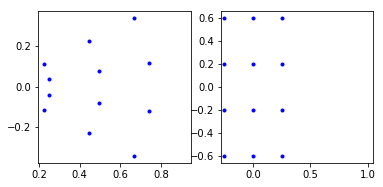

In [330]:
plt.subplot(1,2,1); plt.plot(s[:,0], s[:,1], 'b.'); plt.axis('square');
plt.subplot(1,2,2); plt.plot(e[:,0], e[:,1], 'b.'); plt.axis('square');

## Create Neural Network

In [84]:
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=2)) # 0
net.AddLayer(Layer.PELayer(n=6))      # 1
net.AddLayer(Layer.PELayer(n=8))      # 2
net.AddLayer(Layer.TopPELayer(n=10))  # 3 (augmented)
net.AddLayer(Layer.TopPELayer(n=2))   # 4
net.Connect(0,1)
net.Connect(1,2)
net.Connect(2,3)
net.Connect(2,4)
net.layers[3].SetActivationFunction('tanh')
net.layers[3].SetFF()  # Augmenting layers have no upper input
net.layers[4].sigma = Layer.tanh
net.layers[4].sigma_p = Layer.tanh_p
net.SetTau(0.02)

In [742]:
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=2)) # 0
net.AddLayer(Layer.PELayer(n=10))     # 1
net.AddLayer(Layer.PELayer(n=15))     # 2
net.AddLayer(Layer.TopPELayer(n=2))   # 3
net.Connect(0,1)
net.Connect(1,2)
net.Connect(2,3)
net.layers[0].SetActivationFunction('identity')
net.layers[1].SetActivationFunction('tanh')
net.layers[2].SetActivationFunction('tanh')
net.layers[-1].SetActivationFunction('identity')
net.SetTau(0.08)

In [743]:
net.Reset()
net.SetTau(0.08)
yy = net.Predict(10., test[0], dt=0.005)
y_true = test[1]
y = np.array([np.array(net.layers[-1].sigma(k)) for k in yy])

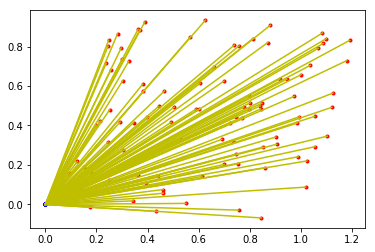

In [744]:
n = 100
plt.plot(np.array(y_true[:n,0]), np.array(y_true[:n,1]), 'r.')
plt.plot(np.array(y[:n,0]), np.array(y[:n,1]), 'b.')
for k in range(n):
    st = [y_true[k,0], y[k,0]]
    en = [y_true[k,1], y[k,1]]
    plt.plot(st, en, 'y')

### Train

In [763]:
train_shuffle = list(zip(train[0],train[1]))
batch_size = 20
net.learning_tau = torch.tensor(batch_size).float().to(device) * 15.
epochs = 3
fp = FloatProgress(min=0,max=epochs*len(train_shuffle))
display(fp)
T = 3.
for k in range(epochs):
    np.random.shuffle(train_shuffle)
    unzip = list(zip(*train_shuffle))
    batches = NN.MakeBatches(unzip[0], unzip[1], batch_size)
    for x in batches:
        net.Reset()
        net.Infer(T, x[0], x[1])
        fp.value += batch_size

A Jupyter Widget

### Test

In [764]:
net.Reset()
net.SetTau(0.08)
yy = net.Predict(8., test[0], dt=0.01)
y_true = test[1]
y = np.array([np.array(net.layers[-1].sigma(k)) for k in yy])

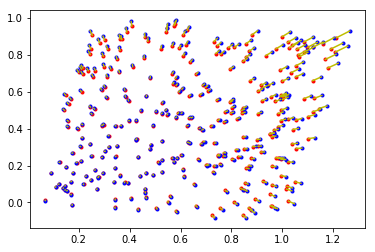

In [765]:
n = 300
plt.plot(np.array(y_true[:n,0]), np.array(y_true[:n,1]), 'r.')
plt.plot(np.array(y[:n,0]), np.array(y[:n,1]), 'b.')
for k in range(n):
    st = [y_true[k,0], y[k,0]]
    en = [y_true[k,1], y[k,1]]
    plt.plot(st, en, 'y')

In [766]:
net.Reset()
net.SetTau(0.08)
xx = net.Generate(8., test[1], dt=0.005)
x_true = test[0]
x = xx #np.array([np.array(net.layers[-1].sigma(k)) for k in yy])

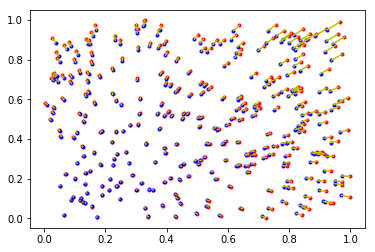

In [767]:
n = 300
plt.plot(np.array(x_true[:n,0]), np.array(x_true[:n,1]), 'r.')
plt.plot(np.array(x[:n,0]), np.array(x[:n,1]), 'b.')
for k in range(n):
    st = [x_true[k,0], x[k,0]]
    en = [x_true[k,1], x[k,1]]
    plt.plot(st, en, 'y')

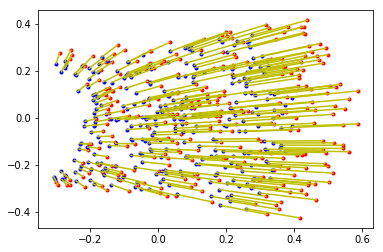

In [735]:
n = 300
plt.plot(np.array(testing_output[:n,0]), np.array(testing_output[:n,1]), 'r.');
plt.plot(np.array(x[:n,0]), np.array(x[:n,1]), 'b.')
for k in range(n):
    st = [testing_output[k,0], x[k,0]]
    en = [testing_output[k,1], x[k,1]]
    plt.plot(st, en, 'y')

In [490]:
for yy, t in zip(y[:15], y_true[:15]):
    print(np.round(yy, decimals=3), np.array(t))
    #print(np.round(np.array(yy)-np.array(t), decimals=3))

[0.628 0.366] [0.6547746  0.33853486]
[0.244 0.23 ] [0.20410204 0.31597096]
[0.574 0.504] [0.48828074 0.65719   ]
[0.991 0.601] [0.9926051 0.5559432]
[0.876 0.53 ] [0.88543373 0.49677342]
[0.783 0.551] [0.7436217  0.60653234]
[0.949 0.594] [0.9395586 0.5735738]
[0.371 0.164] [0.4233272  0.09798532]
[0.803 0.72 ] [0.6495879  0.93644696]
[0.808 0.689] [0.6796795 0.8689658]
[0.763 0.483] [0.76373553 0.48201358]
[0.351 0.263] [0.33379197 0.31371447]
[0.801 0.391] [0.8775355  0.26712164]
[0.784 0.389] [0.8561449  0.27537334]
[0.184 0.064] [0.22020698 0.01519799]


## Train

In [259]:
train_shuffle = list(zip(train[0],train[1]))
batch_size = 10
net.learning_tau = torch.tensor(batch_size).float().to(device) * 5.
epochs = 20
fp = FloatProgress(min=0,max=epochs*len(train_shuffle))
display(fp)
T = 4.
start_time = time.time()
for k in range(epochs):
    np.random.shuffle(train_shuffle)
    unzip = list(zip(*train_shuffle))
    batches = NN.MakeBatches(unzip[0], unzip[1], batch_size)
    for x in batches:
        #net.Reset()
        net.Infer(T, x[0], x[1])
        fp.value += batch_size
end_time = time.time()
print('Total time: '+str(end_time-start_time))

A Jupyter Widget

Total time: 39.79322910308838


In [19]:
net.Save('bin8-5.npy')

In [14]:
net = NN.NeuralNetwork()
net.Load('bin8-5.npy')

## Test

### Run the model on the test dataset

In [260]:
net.Reset()
net.SetTau(0.03)  # it seems like choosing a value half of that during training works best
yy = net.Predict(10., test[0])
y_true = test[1]
y = np.array([np.array(net.layers[-1].sigma(k)) for k in yy])

In [261]:
for yy, t in zip(y[:10], y_true[:10]):
    print(np.round(yy, decimals=3), np.array(t))
    #print(np.array(t))

[0.99  0.001 0.002 0.005 0.002] [1. 0. 0. 0. 0.]
[0.    0.992 0.005 0.    0.002] [0. 1. 0. 0. 0.]
[0.001 0.001 0.992 0.005 0.001] [0. 0. 1. 0. 0.]
[0.002 0.001 0.001 0.994 0.002] [0. 0. 0. 1. 0.]
[0.    0.019 0.    0.    0.981] [0. 0. 0. 0. 1.]
[0.99  0.001 0.002 0.005 0.002] [1. 0. 0. 0. 0.]
[0.    0.992 0.005 0.    0.002] [0. 1. 0. 0. 0.]
[0.001 0.001 0.992 0.005 0.001] [0. 0. 1. 0. 0.]
[0.002 0.001 0.001 0.994 0.002] [0. 0. 0. 1. 0.]
[0.    0.019 0.    0.    0.981] [0. 0. 0. 0. 1.]


In [262]:
net.Reset()
net.SetTau(0.08)  # it seems like choosing a value half of that during training works best
yy = net.Generate(10., test[1])
y_true = test[0]
y = yy

In [264]:
for yy, t in zip(y[:10], y_true[:10]):
    #print(np.round(np.array(yy), decimals=3),np.array(t))
    print(np.round(np.array(yy)-np.array(t), decimals=3))

[-0.023  0.031 -0.013  0.005  0.089 -0.081 -0.07   0.094]
[ 0.002  0.069  0.179 -0.052  0.191 -0.12  -0.123  0.138]
[ 0.051 -0.025 -0.038 -0.04  -0.009  0.035  0.18  -0.049]
[ 0.029 -0.008  0.171 -0.086 -0.003  0.024  0.045 -0.089]
[-0.232  0.21  -0.161  0.057 -0.034  0.013  0.037  0.023]
[-0.023  0.031 -0.013  0.005  0.089 -0.081 -0.07   0.094]
[ 0.002  0.069  0.179 -0.052  0.191 -0.12  -0.123  0.138]
[ 0.051 -0.025 -0.038 -0.04  -0.009  0.035  0.18  -0.049]
[ 0.029 -0.008  0.171 -0.086 -0.003  0.024  0.045 -0.089]
[-0.232  0.21  -0.161  0.057 -0.034  0.013  0.037  0.023]


In [189]:
idx = 7
print(test[1][idx])
print(yy[idx])
print(y_true[idx])

tensor([ 0.,  1.,  1.,  0.])
tensor([ 1.1810,  0.2368,  0.1894,  1.1132, -0.0825,  1.5016,  0.5182,
         1.0331])
tensor([ 1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.])


In [21]:
net.Reset()
yy = net.Predict(10., rand[0])
print(yy)

tensor([[ 0.0731,  0.0255,  0.1281,  0.7320,  0.0413],
        [ 0.0930,  0.0655,  0.1397,  0.6663,  0.0354],
        [ 0.0738,  0.1540,  0.7594,  0.0093,  0.0035],
        [ 0.1176,  0.0130,  0.1431,  0.7110,  0.0153],
        [ 0.0778,  0.0362,  0.1060,  0.7504,  0.0296],
        [ 0.2225,  0.0267,  0.0780,  0.6637,  0.0091],
        [ 0.7609,  0.0103,  0.0708,  0.0543,  0.1038],
        [ 0.7558,  0.0114,  0.0109,  0.1828,  0.0391],
        [ 0.0866,  0.0272,  0.0732,  0.7665,  0.0464],
        [ 0.1820,  0.0777,  0.7241,  0.0110,  0.0053],
        [ 0.1225,  0.0244,  0.0161,  0.0208,  0.8163],
        [ 0.0948,  0.0390,  0.1569,  0.6444,  0.0650],
        [ 0.0747,  0.0553,  0.0829,  0.7534,  0.0337],
        [ 0.0867,  0.0400,  0.1195,  0.7042,  0.0496],
        [ 0.1035,  0.0851,  0.7673,  0.0311,  0.0130],
        [ 0.7433,  0.0139,  0.0334,  0.1411,  0.0682],
        [ 0.2185,  0.0341,  0.0984,  0.6277,  0.0212],
        [ 0.0928,  0.1075,  0.7412,  0.0433,  0.0153],
        [ 

In [53]:
fooled_count = 0
max_confidence = 0.
total_confidence = 0.
for yyy in yy:
    est_class = np.argmax(yyy)
    confidence = yyy[est_class]
    if confidence>max_confidence:
        max_confidence = confidence
        #max_confidence_idx = idx
        #max_confidence_class = est_class
        #best_fooler = random_x
        #print(str(max_confidence_class))
    if confidence>0.95:
        fooled_count += 1
        #print(str(np.round(random_x,3))+' '+str(s[est_class])+' '+str(np.round(sm,3)))
        
    total_confidence += yyy[est_class]
    
print('Fooled ' + str(float(fooled_count*100.)/len(rand)) + '%')
print('Max Confidence   ' + str(max_confidence))
print('Average Confidence ' + str(total_confidence/len(rand)))

Fooled 5000.0%
Max Confidence   tensor(2.8451)
Average Confidence tensor(115.8933)


In [271]:
# Test for binary strings dataset
fail = 0
for x,t in zip(yy, y_true):
    if np.isnan(t).any() or torch.min(x*t).le(0.):
        fail += 1
n_trials = float(len(y_true))
print('Accuracy '+str((n_trials-fail)/n_trials*100.)+'%')

Accuracy 0.0%


In [273]:
# Test for polar clusters dataset
fail = 0
for x,t in zip(yy, y_true):
    if np.isnan(t).any() or torch.max(abs(x-t)).ge(0.2):
        fail += 1
n_trials = float(len(test[0]))
print('Accuracy '+str((n_trials-fail)/n_trials))

Accuracy 1.0


In [58]:
idx = np.random.randint(len(test[0]))
net.Reset()
print(net.Predict(5., test[0][idx]))
print(test[1][idx])

tensor([ 0.1699,  0.1597,  0.1946,  0.3365,  0.1393])
tensor([ 0.,  1.,  0.,  0.,  0.])


In [56]:
net2 = NN.NeuralNetwork()
net2.Load('blah.npy')

In [406]:
np.shape(net2.W[1])

torch.Size([6, 7])

In [59]:
net2.Reset()
print(net2.Predict(5., test[0][idx]))
print(test[1][idx])

tensor([nan., nan., nan., nan., nan.])
tensor([ 0.,  1.,  0.,  0.,  0.])


In [250]:
print(np.shape(net2.layers[1].dvdt))
print(np.shape(net2.W[0]))
print(np.shape(net2.layers[0].e))
print(np.shape(net2.M[0]))
print(np.shape(net2.layers[1].v))

torch.Size([7])
torch.Size([7, 8])
torch.Size([8])
torch.Size([8, 7])
torch.Size([7])


In [251]:
print(np.shape(net.layers[1].dvdt))
print(np.shape(net.W[0]))
print(np.shape(net.layers[0].e))
print(np.shape(net.M[0]))
print(np.shape(net.layers[1].v))

torch.Size([7])
torch.Size([7, 8])
torch.Size([8])
torch.Size([8, 7])
torch.Size([7])


In [664]:
idx = np.random.randint(len(test[1]))
xx = net.Generate(10., test[1][idx])
print(xx)
print(test[0][idx])

tensor([ 0.5916, -0.5986, -0.8456, -0.7550,  0.8802, -0.8882,  0.5235,
         1.1115])
tensor([ 1., -1., -1., -1.,  1., -1.,  1.,  1.])


In [663]:
idx = 2
print(np.round(x_true[idx:idx+5],0)-np.round(x_est[idx:idx+5],0))

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


In [39]:
idx = 58
print(train[1][idx])
net.Predict(10., train[0][idx])

[-1. -1. -1. -1.]


tensor([ 0.9986,  0.9992, -0.9991,  0.9972], device='cuda:0')